In [2]:
import os, torch
import numpy as np
from matplotlib import pyplot as plt

from scripts.utils.imutils import im_to_numpy
import scripts.models as models
%matplotlib inline


In [3]:
import cv2
resume_path = './27kpng_model_best.pth.tar' # path of pretrained model
image_folder = './sample_images'
images = [cv2.imread(os.path.join(image_folder,im)) for im in os.listdir(image_folder) if im.endswith('.png') or im.endswith('.jpg')]
print("Number of test images: ",len(images))

Number of test images:  10


C:\Users\seminal\anaconda3\envs\SeminalWatermark\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Figure size 8000x8000 with 0 Axes>

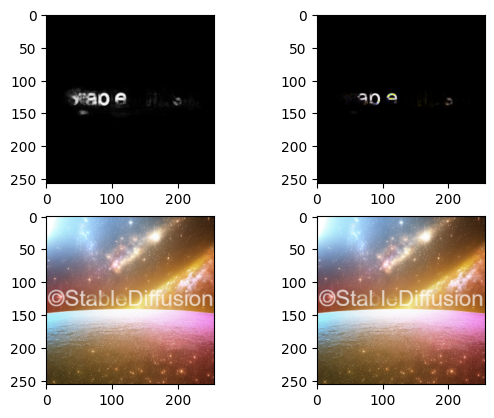

<Figure size 8000x8000 with 0 Axes>

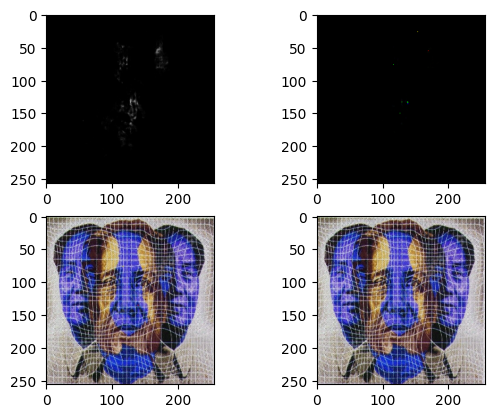

<Figure size 8000x8000 with 0 Axes>

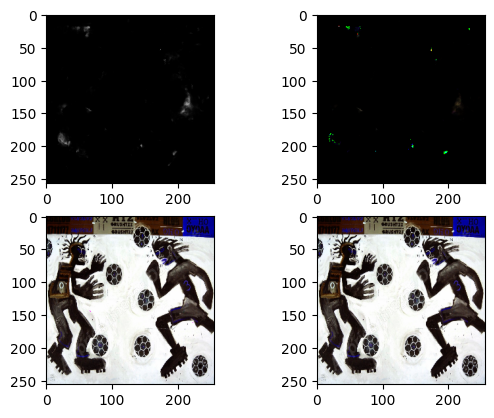

<Figure size 8000x8000 with 0 Axes>

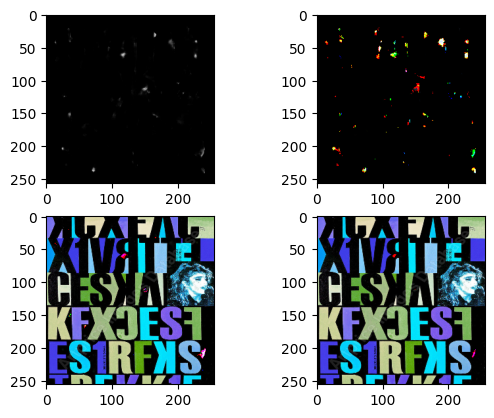

<Figure size 8000x8000 with 0 Axes>

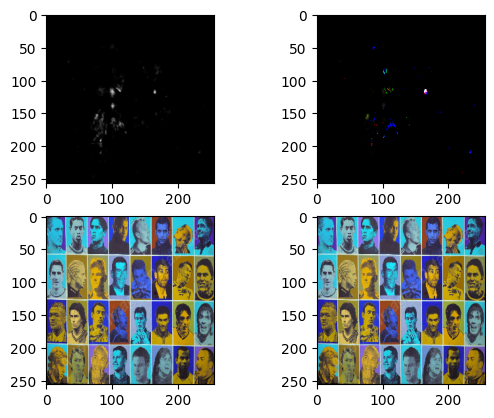

<Figure size 8000x8000 with 0 Axes>

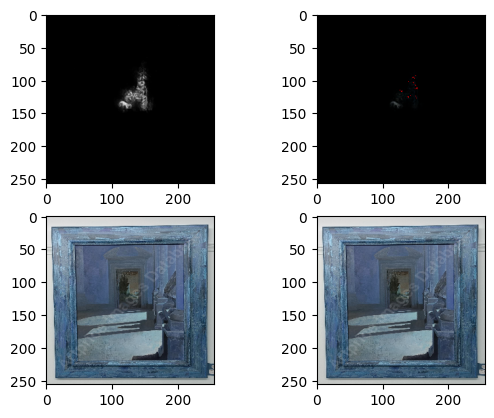

<Figure size 8000x8000 with 0 Axes>

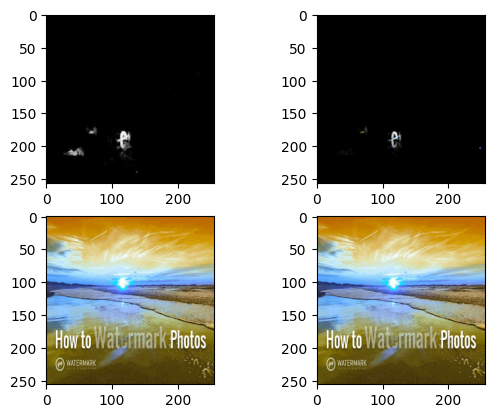

<Figure size 8000x8000 with 0 Axes>

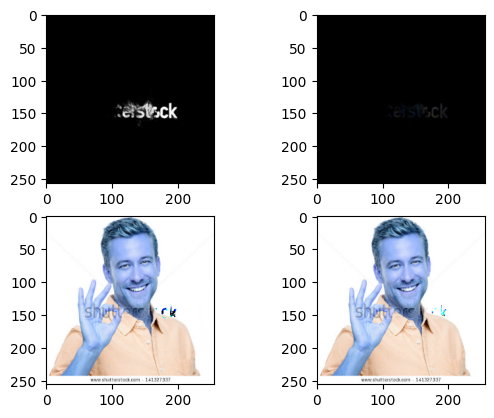

<Figure size 8000x8000 with 0 Axes>

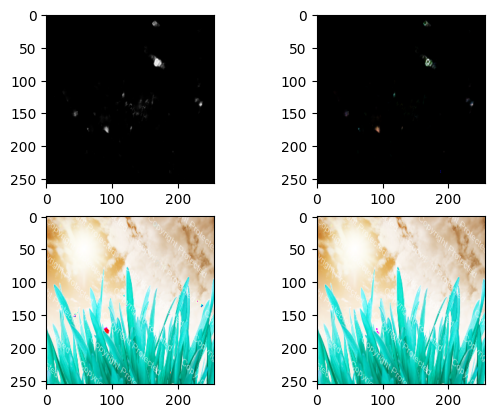

<Figure size 8000x8000 with 0 Axes>

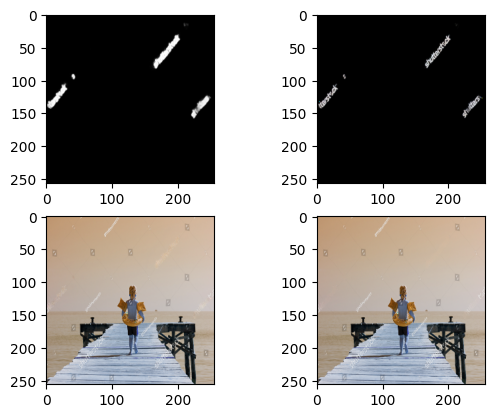

In [4]:
with torch.no_grad():

      model = models.__dict__['vvv4n']().cuda()
      model.load_state_dict(torch.load(resume_path)['state_dict'])
      model.eval()
      
      for i, batches in enumerate(images):
          
          plt.figure(figsize=(80,80))

          batches = cv2.resize(batches,(256,256,))

          im = torch.from_numpy(batches).permute(2,0,1).unsqueeze(0).float().cuda()/255.0
          
          imoutput,immask,imwatermark = model(im)
        
          imcoarser,imrefine,imwatermark = imoutput[1]*immask + im*(1-immask),imoutput[0]*immask + im*(1-immask),imwatermark*immask

          
          imcoarser, imrefine  = im_to_numpy((imcoarser[0]*255)).astype(np.uint8), im_to_numpy((imrefine[0]*255)).astype(np.uint8)
          immask, imwatermark = im_to_numpy((immask.repeat(1,3,1,1)[0]*255)).astype(np.uint8),im_to_numpy((imwatermark[0]*255)).astype(np.uint8)
         
          
          cv2.imwrite(os.path.join(image_folder, str(i)+"immask.jpg"),immask)
          cv2.imwrite(os.path.join(image_folder, str(i)+"imrefine.jpg"),imrefine)
          
          f, axarr = plt.subplots(2,2)
          axarr[0,0].imshow(immask,vmin=0.0,vmax=255.0)
          axarr[0,1].imshow(imwatermark,vmin=0.0,vmax=255.0)
          axarr[1,0].imshow(imcoarser,vmin=0.0,vmax=255.0)
          axarr[1,1].imshow(imrefine,vmin=0.0,vmax=255.0)
          plt.show()

